In [1]:
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt

import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature

from MapXtremePCIC import MapXtremePCIC

In [2]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC(50, 'eof', PATH)
data_cube = MapXtreme.load_data

In [3]:
data_cube

<xarray.Dataset>
Dimensions:  (rlat: 124, rlon: 149, run: 35, x: 124, y: 149)
Coordinates:
    lon      (x, y) float64 233.5 233.8 234.2 234.6 ... 331.5 332.0 332.5 333.0
    lat      (x, y) float64 14.04 14.2 14.36 14.51 ... 60.17 59.87 59.56 59.26
  * rlon     (rlon) float64 -32.56 -32.12 -31.68 -31.24 ... 31.68 32.12 32.56
  * rlat     (rlat) float64 -27.28 -26.84 -26.4 -25.96 ... 25.96 26.4 26.84
Dimensions without coordinates: run, x, y
Data variables:
    pr       (x, y, run) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    pr:       mm h-1
    lon:      degrees
    lat:      degrees
    rlon:     degrees
    rlat:     degrees

In [4]:
X_prime = MapXtreme.ensemble_mean(data_cube)

In [5]:
X = MapXtreme.weight_matrix(data_cube)

In [6]:
X_prime.shape

(35, 18476)

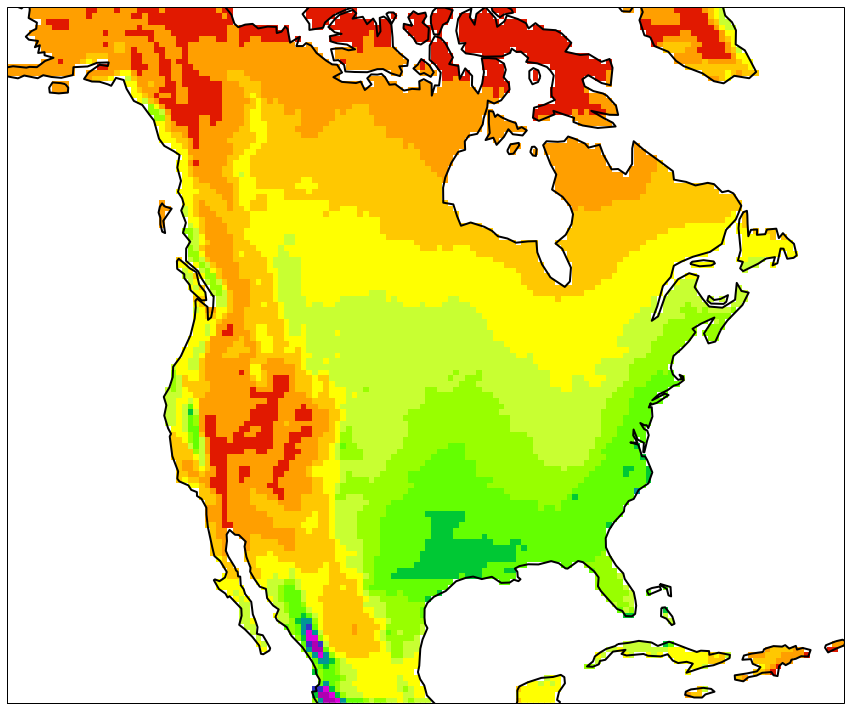

In [7]:
MapXtreme.plot_reference(data_cube)

In [9]:
help(MapXtreme.plot_reference)

Help on method plot_reference in module MapXtremePCIC:

plot_reference(data_cube) method of MapXtremePCIC.MapXtremePCIC instance
    Plots the mean value along the run axis of CanRCM4 simulations
    
    Parameters
    ----------
    xarray dict : Data cube with geospatial and field data for ensemble of CanRCM4 data
    
    Returns
    -------
    out : matplotlib axis object

